# Multilayer perceptron
In this notebook, a narrow multilayer perceptron (MLP) model is implemented in Pytorch.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F

import seaborn as sns; sns.set()
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
# Select device which you are going to use for training
device = torch.device("cuda:0")
# device = torch.device("cpu")

## Load data
The data set that is used is the [**Wine Quality Data Set**](https://archive.ics.uci.edu/ml/datasets/Wine+Quality).

In [3]:
red_wine = pd.read_csv("../data/winequality-red.csv", delimiter=';')
white_wine = pd.read_csv("../data/winequality-white.csv", delimiter=';')
data = pd.concat([red_wine, white_wine])
data.tail()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
4893,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,6
4894,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,5
4895,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,6
4896,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,7
4897,6.0,0.21,0.38,0.8,0.020,22.0,98.0,0.98941,3.26,0.32,11.8,6


The attribute `quality` is our dependent variable that we are trying to predict, so it will be dropped from the features.

In [4]:
features = torch.Tensor(data.loc[:,data.columns!='quality'].values)
labels = torch.Tensor(data.quality.values)
features.shape, labels.shape

(torch.Size([6497, 11]), torch.Size([6497]))

In [5]:
labels.unique()

tensor([3., 4., 5., 6., 7., 8., 9.])

We transform the labels so that this becomes a binary classification problem:
- `y=0` if the wine quality is deemed less than 7,
- `y=1` if the wine quality is deemed greater or equal than 7.

In [6]:
labels = (labels >= 7).float().view(-1,1)

## Create train and test splits
20% of the data will be used for testing, the rest will be used for training.
The split will be performed by randomly subsampling from the the data set.

In [7]:
(train_feats, test_feats, 
 train_labels, test_labels) = train_test_split(features, labels, test_size=.2,
                                           random_state=42)

In [8]:
# Check shapes
print(f"Features : {train_feats.shape}, {test_feats.shape}")
print(f"Labels : {train_labels.shape}, {test_labels.shape}")

Features : torch.Size([5197, 11]), torch.Size([1300, 11])
Labels : torch.Size([5197, 1]), torch.Size([1300, 1])


## Standardize the features
In order to facilitate the optimization problem, we will standardize the features, that is:
- **zero mean**: the mean is subtracted from the data point along each feature,
- **unit variance**: each feature is divided by its standard deviation.
<div class="alert alert-block alert-info">
It is important to notice that this preprocessing step should be performed using the statistics obtained in the training set only.
Otherwise, we would suffer <b>data leakage</b>: information from the test set would be used, which would not be possible in the real scenario.
</div>

In [9]:
scaler = StandardScaler()
scaler.fit(train_feats)
train_feats = scaler.transform(train_feats)
test_feats = scaler.transform(test_feats)

In [10]:
# Check scaling
np.mean(train_feats[:,0])

2.645565121600527e-16

In [11]:
# Transform features back to torch tensors
train_feats = torch.Tensor(train_feats)
test_feats = torch.Tensor(test_feats)
train_feats.shape, test_feats.shape

(torch.Size([5197, 11]), torch.Size([1300, 11]))

## Build MLP classifier
Here, we build the MLP model.

In [12]:
class MLP(nn.Module):
    def __init__(self, n_inputs=11):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(n_inputs, 200)
        self.fc2 = nn.Linear(200, 100)
        self.fc3 = nn.Linear(100, 1)

    def forward(self, x):
        """
        Args:
          x of shape (n_samples, n_inputs): Model inputs.
        
        Returns:
          y of shape (n_samples, 1): Model outputs.
        """
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        y = torch.sigmoid(self.fc3(x))
        return y

## Model training

In [13]:
# Compute the accuracy of the model on the given dataset
def compute_accuracy(model, inputs, targets):
    with torch.no_grad():
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = (model.forward(inputs) > 0.5).float()
        accuracy = (outputs == targets).sum().float() / targets.numel()
        return accuracy

In [27]:
# Create the model
model = MLP()
model.to(device)

MLP(
  (fc1): Linear(in_features=11, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=1, bias=True)
)

In [28]:
train_acc = []
train_feats, train_labels = train_feats.to(device), train_labels.to(device)
for iter in range(8000):
    model.zero_grad()
    out = model(train_feats)
    loss = F.binary_cross_entropy(out, train_labels)
    loss.backward()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    if iter % 100 == 0:
        train_acc_iter = compute_accuracy(model, train_feats, train_labels)
        train_acc.append(train_acc_iter)
    optimizer.step()

Text(0.5, 1.0, 'Evolution of training accuracy')

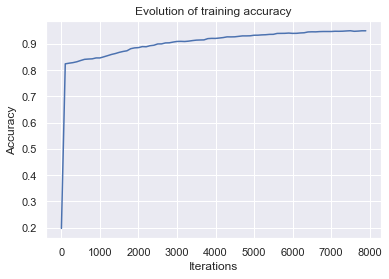

In [31]:
plt.plot(np.arange(0,8000, 100), train_acc)
plt.xlabel("Iterations")
plt.ylabel("Accuracy")
plt.title("Evolution of training accuracy")

In [30]:
test_acc = compute_accuracy(model, test_feats, test_labels)
print(f"The model converged to a training accuracy of {train_acc[-1]}.")
print(f"The model achieved a test accuracy of {test_acc}")

The model converged to a training accuracy of 0.9497787356376648.
The model achieved a test accuracy of 0.86307692527771


# Conclussion
Now we can observe that the MLP model achieved a high training accuracy of 0.95. This is superior to the logistic regression model that we trained before. Now, there is no underfitting, the model has **low bias**. This is because, the model can learn a hypothesis which is complex enough to more accuractely map the input space to the target space.

However, although the training accuracy has improved significantly, the improvement in the test accuracy with respect to the logistic regression model is not as big. Here we can see that the model is suffering from **high variance**. We are using a model that can learn a very complex hypothesis and that is causing the model to learn a very complex function that works very well on the training data but does **not generalize** well to the test set.
In other words, the model has learned 

In order to fix this, we can employ different strategies:
- Increase the training data by:
    - performing data augmentation or
    - collecting more data,
- Using regularization techniques such as:
    - Early stopping (monitoring the out-of-sample error and stop training when no improvement is achieved after some iterations)
    - L2 or L1 norm regularization (adding a term to the loss function that penalizes large weights),
    - Dropout (dropping neurons with a certaing probability during training only so that the model does not learn to rely on onyl a subset of the features)
Plenty of other strategies can be employed as well.